In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
from helper_functions.import_dmr import *
from helper_functions.categorize_parameters import *

### Import Parameter Code List

In [2]:
ref_parameter_df = pd.read_csv('data/dmrs/REF_Parameter.csv')
ir_parameter_df = pd.read_csv('data/ir/ir_parameter_list.csv', dtype=str)
esmr_parameter_df = pd.read_csv('data/esmr/esmr_parameters.csv')

### Find Relevant Parameters based on Monitoring Dataset

In [3]:
esmr_data = read_esmr(save=False, load=True)
data_dict = read_all_dmrs(save=False, load=True)

all_pollutants, all_parameter_codes = [], []
for year in analysis_range:
    all_pollutants = np.concatenate([all_pollutants, data_dict[year]['POLLUTANT_CODE'].unique()])
    all_parameter_codes = np.concatenate([all_parameter_codes, data_dict[year]['PARAMETER_CODE'].unique()])
unique_pollutants, unique_parameter_codes = np.unique(all_pollutants), np.unique(all_parameter_codes)
print(f'{len(unique_pollutants)} unique pollutants and {len(unique_parameter_codes)} unique parameters')

/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/import_dmr.py:152: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('processed_data/esmr_data.csv')


158 unique pollutants and 181 unique parameters


In [4]:

ref_parameter_df = categorize_parameters(ref_parameter_df, parameter_sorting_dict, 'PARAMETER_DESC')
ir_parameter_df = categorize_parameters(ir_parameter_df, parameter_sorting_dict, 'IR_PARAMETER_DESC')
esmr_parameter_df = categorize_parameters(esmr_parameter_df, parameter_sorting_dict, 'ESMR_PARAMETER_DESC')

# additional categorization of Total Toxics
mask = ref_parameter_df['PARAMETER_CODE'].str.startswith(('T', 'W'))
ref_parameter_df.loc[mask, 'PARENT_CATEGORY'] = 'Total Toxics'
ref_parameter_df.loc[mask, 'SUB_CATEGORY'] = ''

# save to csv
ref_parameter_df.to_csv('processed_data/REF_Parameter.csv', index=False)
ir_parameter_df[['IR_PARAMETER_DESC', 'PARENT_CATEGORY', 'SUB_CATEGORY']].to_csv('processed_data/ir_parameter_list.csv', index=False)
esmr_parameter_df.to_csv('processed_data/esmr_parameters.csv', index=False)


/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(sub_value['values']), case=False)
/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(sub_value['values']), case=False)
/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions/categorize_parameters.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[desc_column].str.contains('|'.join(sub_value['values']), case=False)


In [5]:
esmr_parameter_df

,ESMR_PARAMETER_DESC,CATEGORY,PARENT_CATEGORY,SUB_CATEGORY
0,Flow,Flow,Flow,
1,Total Coliform,Toxic Organics,Toxic Organics,Toxic Organic Snippets
2,pH,pH,pH,case-sensitive
3,"Total Suspended Solids (TSS), Percent Removal",Non-dissolved Solids,Non-dissolved Solids,
4,Dissolved Oxygen,Dissolved Oxygen,Dissolved Oxygen,
...,...,...,...,...
795,N-Methyl perfluorooctane sulfonamidoethanol,Toxic Organics,Toxic Organics,Toxic Organic Snippets
796,Azobenzene,Toxic Organics,Toxic Organics,Toxic Organic Snippets
797,Ammonium as Nitrogen,Nutrients,Nutrients,Nitrogen
798,Demeton-S,Toxic Organics,Toxic Organics,Toxic Organic Snippets


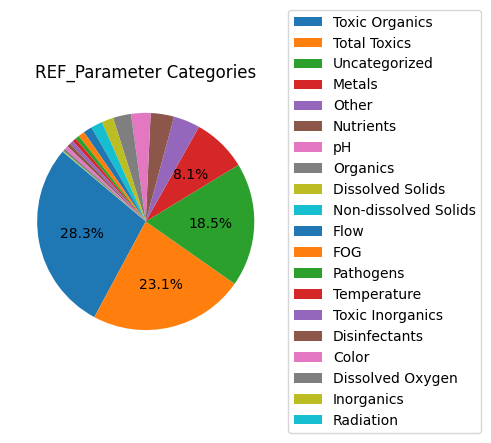

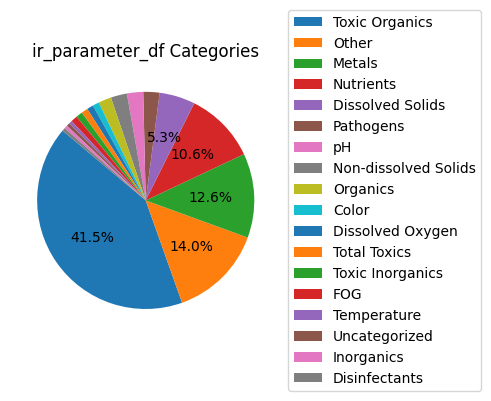

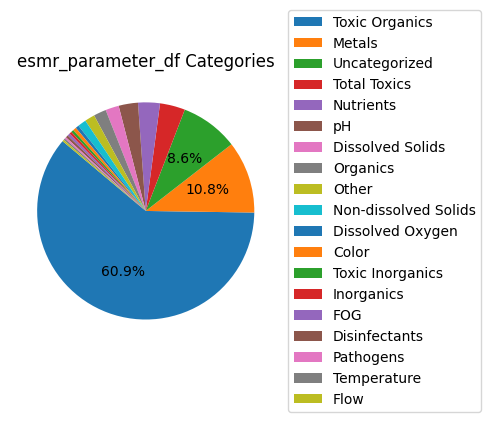

In [6]:
plot_pie_counts(ref_parameter_df, 'REF_Parameter Categories')
plot_pie_counts(ir_parameter_df, 'ir_parameter_df Categories')
plot_pie_counts(esmr_parameter_df, 'esmr_parameter_df Categories')

In [7]:
# parameter_categories = {}

# for key in parameter_sorting_dict.keys():
#     parameter_categories[key] = {}
#     parameter_categories[key]['EPA ICIS DMRs'] = ref_parameter_df[ref_parameter_df['CATEGORY'] == key]['PARAMETER_DESC'].tolist()
#     parameter_categories[key]['ir Impaired List'] = ir_parameter_df[ir_parameter_df['CATEGORY'] == key]['IR_PARAMETER_DESC'].tolist()
#     parameter_categories[key]['eSMRs'] = esmr_parameter_df[esmr_parameter_df['CATEGORY'] == key]['ESMR_PARAMETER_DESC'].tolist()

# # save parameter_categories to file
# with open('processed_data/parameter_categories.json', 'w') as f:
#     json.dump(parameter_categories, f)

### Make a list of pollutant codes

In [8]:
# Create a list of unique pollutant codes and their corresponding parameter descriptions
unique_pollutants = ref_parameter_df[['POLLUTANT_CODE', 'PARAMETER_DESC']].drop_duplicates(subset='POLLUTANT_CODE', keep='first')
# Save the list to a CSV file
unique_pollutants.to_csv('processed_data/pollutant_names.csv', index=False)

### Create a master list of parameter codes and descriptions by matching the parameter names

In [9]:

dmr_params_df = pd.DataFrame({'PARAMETER_CODE': unique_parameter_codes}).merge(
    ref_parameter_df[['PARAMETER_CODE', 'PARAMETER_DESC', 'POLLUTANT_CODE', 'PARENT_CATEGORY']].astype({'POLLUTANT_CODE': int}),
    on='PARAMETER_CODE', how='left'
)

if save:
    esmr_params_df = pd.DataFrame({'PARAMETER_DESC': esmr_data['parameter'].unique()}).merge(
        dmr_params_df[['PARAMETER_DESC', 'PARAMETER_CODE']], on='PARAMETER_DESC', how='left'
    )
    esmr_params_df.to_csv('processed_data/esmr_unique_parameters.csv', index=False)
if load:
    esmr_params_df = pd.read_csv('processed_data/esmr_unique_parameters.csv')
    ir_params_df = pd.read_csv('processed_data/ir_parameter_list.csv')

esmr_params_df['normalized_desc'] = esmr_params_df['PARAMETER_DESC'].apply(normalize_param_desc)
ir_params_df['normalized_desc'] = ir_params_df['IR_PARAMETER_DESC'].apply(normalize_param_desc)
ir_params_df.rename(columns={'IR_PARAMETER_DESC': 'PARAMETER_DESC'}, inplace=True)

dmr_params_df['ESMR_PARAMETER_DESC_MATCHED'] = dmr_params_df.apply(lambda row: match_parameter_desc(row, esmr_params_df), axis=1)
dmr_params_df['IR_PARAMETER_DESC_MATCHED'] = dmr_params_df.apply(lambda row: match_parameter_desc(row, ir_params_df), axis=1)

print(f'{len(dmr_params_df["ESMR_PARAMETER_DESC_MATCHED"].unique()) - 1} out of {len(dmr_params_df)} parameter names match PARAMETER_DESC in REF_PARAMETER.csv')
print(f'{len(dmr_params_df["IR_PARAMETER_DESC_MATCHED"].unique()) - 1} out of {len(dmr_params_df)} parameter names match PARAMETER_DESC in ir_parameters.csv')

# read the manual mappings
dmr_esmr_mapping_manual = pd.read_csv('processed_data/dmr_esmr_mapping_manual.csv')
dmr_ir_mapping_manual = pd.read_csv('processed_data/dmr_ir_mapping_manual.csv')

# Update dmr_params_df with manual mappings
dmr_params_df['ESMR_PARAMETER_DESC_MANUAL'] = dmr_esmr_mapping_manual['ESMR_PARAMETER_DESC_MANUAL'].fillna('')
dmr_params_df['IR_PARAMETER_DESC_MANUAL'] = dmr_ir_mapping_manual['IR_PARAMETER_DESC_MANUAL'].fillna('')

# Consolidate ESMR and IR parameter descriptions
for desc_type in ['ESMR', 'IR']:
    dmr_params_df[f'{desc_type}_PARAMETER_DESC'] = dmr_params_df.apply(
        lambda row: row[f'{desc_type}_PARAMETER_DESC_MATCHED'] if row[f'{desc_type}_PARAMETER_DESC_MATCHED'] != '' 
        else (row[f'{desc_type}_PARAMETER_DESC_MANUAL'] if row[f'{desc_type}_PARAMETER_DESC_MANUAL'] != '' else ''),
        axis=1
    )

dmr_params_df.drop(columns=['ESMR_PARAMETER_DESC_MATCHED', 'ESMR_PARAMETER_DESC_MANUAL', 'IR_PARAMETER_DESC_MATCHED', 'IR_PARAMETER_DESC_MANUAL'], inplace=True)
dmr_params_df.rename(columns={'PARAMETER_DESC': 'DMR_PARAMETER_DESC'}, inplace=True)
dmr_params_df.to_csv('processed_data/dmr_esmr_ir_mapping.csv', index=False)

99 out of 181 parameter names match PARAMETER_DESC in REF_PARAMETER.csv
18 out of 181 parameter names match PARAMETER_DESC in ir_parameters.csv
